# Imports

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import matplotlib.image as mpimg
import tensorflow as tf
import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load Data

In [86]:
df=pd.read_csv('../data/processed_poke.csv')

In [87]:
df=df.query("type=='Water' | type=='Fire'")
df.index=range(len(df))

In [88]:
df.head()

,name,type,filepath
0,charmander,Fire,../data/images/charmander.png
1,charmeleon,Fire,../data/images/charmeleon.png
2,charizard,Fire,../data/images/charizard.png
3,squirtle,Water,../data/images/squirtle.png
4,wartortle,Water,../data/images/wartortle.png


In [89]:
df['onehot']=tf.keras.utils.to_categorical(LabelEncoder().fit_transform(df.type)).tolist()

In [90]:
len(df)

167

In [91]:
df.isna().sum()

name        0
type        0
filepath    0
onehot      0
dtype: int64

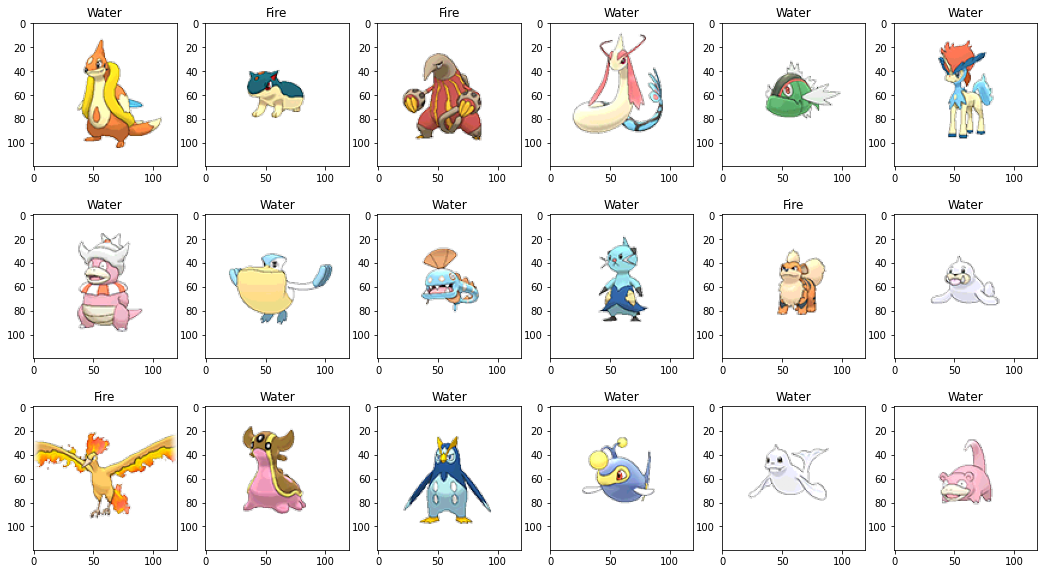

In [93]:
fig,ax=plt.subplots(3,6,figsize=(18,10))

for i in range(3):
    for j in range(6):
        rand=np.random.randint(0,len(df)-1)
        ax[i,j].set_title(df.type[rand])
        ax[i,j].imshow(mpimg.imread(df.filepath[rand]))

# Data Generator

In [94]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2,   
    rescale=1/255
)


train_data = train_gen.flow_from_dataframe(
    df,
    x_col='filepath',
    y_col='type',
    target_size=(120, 120),
    color_mode='rgba',
    class_mode='categorical',
    batch_size=32,
    seed=1,
    subset='training'
)

val_data = train_gen.flow_from_dataframe(
    df,
    x_col='filepath',
    y_col='type',
    target_size=(120, 120),
    color_mode='rgba',
    class_mode='categorical',
    batch_size=32,
    seed=1,
    subset='validation'
)

Found 134 validated image filenames belonging to 2 classes.
Found 33 validated image filenames belonging to 2 classes.


# Make Model

In [97]:
model=tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(120,120,4)))
model.add(tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model.add(tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu'))
model.add(tf.keras.layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu'))
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.Conv2D(filters=256,kernel_size=(3,3),activation='relu'))
model.add(tf.keras.layers.Conv2D(filters=256,kernel_size=(3,3),activation='relu'))
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128,activation='relu'))
model.add(tf.keras.layers.Dense(2,activation='sigmoid'))
model.compile(
    optimizer='adam',                 
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
   metrics=['acc']
)

# print model layers
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_127 (Conv2D)         (None, 118, 118, 64)      2368      
                                                                 
 conv2d_128 (Conv2D)         (None, 116, 116, 64)      36928     
                                                                 
 max_pooling2d_63 (MaxPoolin  (None, 58, 58, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_129 (Conv2D)         (None, 56, 56, 128)       73856     
                                                                 
 conv2d_130 (Conv2D)         (None, 54, 54, 128)       147584    
                                                                 
 max_pooling2d_64 (MaxPoolin  (None, 27, 27, 128)      0         
 g2D)                                                

# Train Model

In [98]:
history = model.fit(
    train_data,
    validation_data=val_data,
    batch_size=32,
    epochs=100,  
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_acc',
            patience=10,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau()
    ]
)

Epoch 1/100
5/5 [==============================] - 7s 1s/step - loss: 0.6784 - acc: 0.5448 - val_loss: 0.7819 - val_acc: 0.7273 - lr: 0.0010
Epoch 2/100
5/5 [==============================] - 7s 2s/step - loss: 1.0044 - acc: 0.6716 - val_loss: 0.6767 - val_acc: 0.7273 - lr: 0.0010
Epoch 3/100
5/5 [==============================] - 7s 2s/step - loss: 0.6860 - acc: 0.6716 - val_loss: 0.6813 - val_acc: 0.7273 - lr: 0.0010
Epoch 4/100
5/5 [==============================] - 7s 1s/step - loss: 0.6753 - acc: 0.6716 - val_loss: 0.6351 - val_acc: 0.7273 - lr: 0.0010
Epoch 5/100
5/5 [==============================] - 7s 1s/step - loss: 0.6270 - acc: 0.6716 - val_loss: 0.5618 - val_acc: 0.7273 - lr: 0.0010
Epoch 6/100
5/5 [==============================] - 7s 1s/step - loss: 0.6480 - acc: 0.6716 - val_loss: 0.6016 - val_acc: 0.7273 - lr: 0.0010
Epoch 7/100
5/5 [==============================] - 7s 2s/step - loss: 0.6247 - acc: 0.6716 - val_loss: 0.5521 - val_acc: 0.7273 - lr: 0.0010
Epoch 8/100
5

# Results
## Accuracy Graph

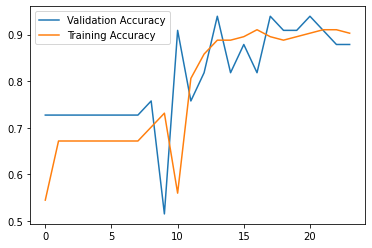

In [103]:
plt.plot(history.history['val_acc'],label='Validation Accuracy')
plt.plot(history.history['acc'],label='Training Accuracy')
plt.legend()

## Loss Graph

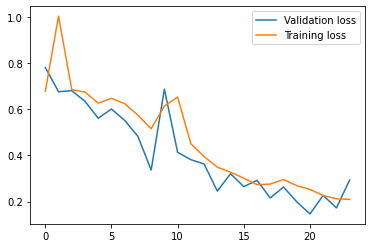

In [104]:
plt.plot(history.history['val_loss'],label='Validation loss')
plt.plot(history.history['loss'],label='Training loss')
plt.legend()

# Save Model

In [105]:
model.save('poke.h5')

# Single Inference

In [121]:
img=mpimg.imread('../data/images/squirtle.png')
np.squeeze(img).shape
out=np.argmax(model.predict(np.expand_dims(img,axis=0)))
print(out)

1/1 [==============================] - 0s 32ms/step
1


# Deploy with interface

In [145]:
import gradio as gr



def classify_image(inp):
  new_image = np.zeros((120, 120, 4))

# Copy the original image to the first three channels of the new array
  new_image[:,:,0:3] = inp[:,:,:]

  model = tf.keras.models.load_model('poke.h5')
  prediction=np.argmax(model.predict(np.expand_dims(new_image,axis=0)))
  prediction=int(prediction)
  if prediction==1:
    return "Water"
  else:
    return "Fire"



gr.Interface(fn=classify_image, 
             inputs=gr.Image(shape=(120,120)),
             outputs=gr.Label(),
            
             ).launch()


Running on local URL:  http://127.0.0.1:7880

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 104ms/step


In [149]:
weights=model.get_weights()

In [150]:
weights

[array([[[[ 0.015167  , -0.02608586, -0.03791809, ..., -0.06180994,
           -0.08648621,  0.03426417],
          [-0.08396576, -0.07913574, -0.08895048, ...,  0.02873088,
            0.00102105, -0.08466027],
          [-0.06791174, -0.02003128, -0.04323013, ...,  0.08971507,
           -0.02362162,  0.06813958],
          [-0.06261192, -0.04114404,  0.0073623 , ...,  0.04511398,
           -0.07995284,  0.08472881]],
 
         [[ 0.05350589, -0.01022479, -0.0032835 , ...,  0.02143922,
            0.01940286, -0.03187185],
          [ 0.00561058, -0.04830559, -0.03396313, ..., -0.04572418,
            0.08107308, -0.01432529],
          [-0.00670794,  0.04859747,  0.00263937, ..., -0.03939719,
           -0.02945345,  0.09504104],
          [ 0.02422974, -0.02520564,  0.07880188, ..., -0.0617528 ,
            0.06378941,  0.07670832]],
 
         [[-0.09537198,  0.06488947,  0.07732603, ...,  0.03841901,
            0.06961137, -0.04326916],
          [-0.02714315,  0.05609801,  0.

In [151]:
len(weights)

16